# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
from IPython.display import Audio

# Log-Frequency-Spectrogram

(Fortführung)

In diesem Notebook werden wir das Log-Freq-Spectrogram aus der Vorlesung zuende implementieren.

Dafür verwenden wir die bisherigen Erkenntnisse aus der Sitzung:

/Users/danielhopfner/opt/miniconda3/envs/abmp/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


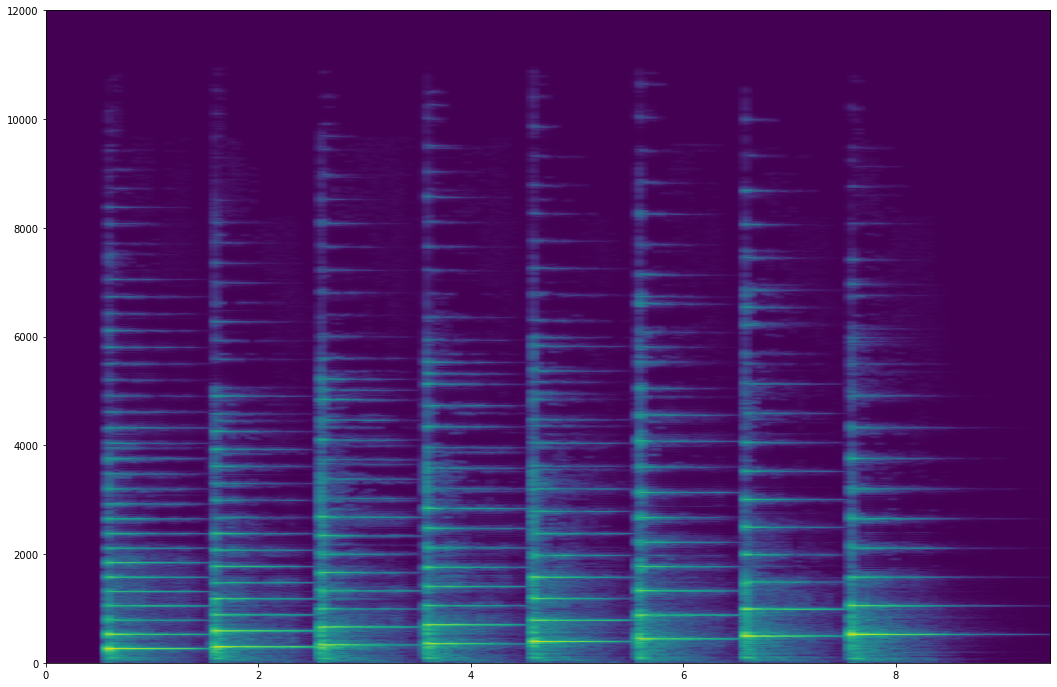

In [2]:
x, sr = lr.load('../../data/piano_scale.mp3', sr=None)
length = x.size / sr
display(Audio(x, rate=sr))

stft = lr.stft(x, n_fft=4096)
gamma = 100
plt.figure(figsize=(18, 12))
plt.imshow(np.log10(1 + np.abs(stft) * gamma), aspect='auto', origin='lower', extent=[0, length, 0, sr / 2])
plt.show()

In [3]:
# können wir anstatt frequenzen pitches im spektrogramm darstellen? (<-- ja!)

# dazu müssten wir die einzelnen frequenz-koeffizienten, die nahe beieinander liegen,
# zu einem pitch zusammenfassen.
# in dem fall nehmen wir immer die grenzen `p - 0.5` `p + 0.5` (also jew. ein viertelton hoch oder runter)
# und summieren alle frequenz-koeffizienten, die sich innerhalb dieser grenzen befinden, auf.

# wir sind damit nicht ganz fertig geworden

p = 69 # beispielhaft für einige vorüberlegungen: p 69 --> 440 Hz

# wiederholung midi to frequency
def mtof(p):
    return 440 * 2 ** ((p - 69) / 12)

print('p %d:\t%0.2f Hz' % (p, mtof(p)))
print('upper:\t%0.2f Hz' % (mtof(p + 0.5)))
print('lower:\t%0.2f Hz' % (mtof(p - 0.5)))

# wiederholung: koeffizienten frequenzen ausrechnen, mit gegebenem frequenz-index `k`
def calc_f_coef(k, sr, N):
    return k * sr / N

window_size = 4096 # window-size der obigen stft
print('f_res:\t%0.2f Hz\n' % (calc_f_coef(k=1, sr=sr, N=window_size)))

# welche frequenz-koeffizienten befinden sich in der dft (oder stft) innerhalb der grenzen `p - 0.5` `p + 0.5`?
def freqs_in_dft(p, sr, N):
    freqs = []
    num_ks = N // 2
    for k in range(num_ks):
        f_coef = calc_f_coef(k=k, sr=sr, N=N)
        if (mtof(p - 0.5) < f_coef < mtof(p + 0.5)):
            freqs.append(f_coef)
    return freqs

print('freqs in p %d:\t%s' % (p, freqs_in_dft(p, sr, window_size)))
p = 60
print('freqs in p %d:\t%s' % (p, freqs_in_dft(p, sr, window_size)))
p = 48
print('freqs in p %d:\t%s' % (p, freqs_in_dft(p, sr, window_size)))

p 69:	440.00 Hz
upper:	452.89 Hz
lower:	427.47 Hz
f_res:	5.86 Hz

freqs in p 69:	[427.734375, 433.59375, 439.453125, 445.3125, 451.171875]
freqs in p 60:	[257.8125, 263.671875]
freqs in p 48:	[128.90625]


-------- 

Anstatt der genauen Frequenzen in Hertz, wollen wir nun aber wissen, welche Frequenz-Indizes ($k$) sich innerhalb der Grenzen ($p - 0.5$, $p + 0.5$) in unserem Spektrogramm befinden

<br/>

<div style="background-color:lightyellow;border:solid grey;padding:10px">

**Aufgabe 1:**
   
Schreibt eine Funktion `ks_in_dft`, die anstatt der Frequenzen, die Indizes $k$ innerhalb der Viertelton-Grenzen für einen gegebenen Pitch ausgibt.
    
Tipps:

- Dazu könnt ihr `freqs_in_dft` zum größten Teil kopieren.
- Anstatt alle Frequenzen in `freqs` zu sammeln, sammeln wir nun alle k's in `ks` (oder einem ähnlichen Variablennamen).
- Dementsprechend muss also auch nicht der Frequenz-Koeffizient `f_coef` in den Array angefügt (`append`et) werden, sondern das jeweilige `k` im Loop.

</div>

In [ ]:
# welche frequenz-indizes (k) befinden sich in der dft (oder stft) innerhalb der grenzen `p - 0.5` `p + 0.5`?
# def ks_in_dft(p, sr, N):
#    ...
#    return ks


p = 69
print('ks in p %d:\t%s' % (p, ks_in_dft(p, sr, window_size)))
p = 60
print('ks in p %d:\t%s' % (p, ks_in_dft(p, sr, window_size)))
p = 48
print('ks in p %d:\t%s' % (p, ks_in_dft(p, sr, window_size)))

-----

Jetzt müssen wir nur noch das Log-Frequency-Spectrogram zusammenfügen:

<br/>

<div style="background-color:lightyellow;border:solid grey;padding:10px">

**Aufgabe 2:**
   
Schreibt eine Funktion `stft_to_logfreq`, die aus einer STFT ein Log-Frequency-Spectrogram berechnet.
    
Tipps:

- Erstellt einen Array mit Nullen (`np.zeros`), der schon den richtigen `shape` hat: Anstatt `window_size` verschiedene Frequenzen haben wir nun 128 pitches in jeder Zeile (`shape[0]`), `shape[1]` muss, also die Anzahl der berechneten Fenster, dem der STFT entsprechen.
- Jetzt muss jeder Pitch-Koeffizient innerhalb eines Loops berechnet werden (ingesamt 128 pitches, also $0$ bis $127$)
- Innerhalb jedes Iterationsschritts benötigen wir die entsprechenden `ks` (Frequenz-Indizes) des jeweiligen Pitch (dafür können wir die Funktion `ks_in_dft` verwenden).

</div>

In [ ]:
def stft_to_logfreq(stft, sr):
    logfreq = ...
    window_size = stft.shape[0]
    for ...:
        ks = ...
        logfreq[p, :] = np.sum(np.abs(stft[ks, :]), axis=0) # hier werden alle koeffizienten an den stellen `ks` aufsummiert
    return logfreq

logfreq = stft_to_logfreq(stft, sr)

# plot
gamma = 1
plt.figure(figsize=(24, 18))
plt.imshow(np.log10(1 + np.abs(logfreq) * gamma), aspect='auto', origin='lower', extent=[0, length, 0, 128])
plt.show()

Mit guten Augen und einem großen Bildschirm kann man sogar die Halbton-Schritte von Stufe iii/iv und vii/i der Dur-Tonleiter gut beobachten (versucht mal Rechtsklick auf das gerenderte Spektrogramm --> "Bild in neuem Tab öffnen" und lasst euch das Bild in voller Größe anzeigen).